# Nuclei Detection using CNNs and U-net Architecture with Data Augmentation

+ I will be trying two to three architectures and finally report the LB scores 
+ I will put down the benifits and disadvantages of each approach
+ I will add Data augmentation here also for this trial


## Steps From Start to Finish 
1. Imports and Tools to Use for this project
2. Import the Data using Floydhub Jupyter instance
3. Analyze the Data
4. Understanding the IOU metric and writing its custom definition for the mean IOU function
5. Defining the Architecture/model to be used
6. Training the Network 
7. Make predictions on the Training , Validation and the test sets
8. RLE Encoding and Submitting the results

**Steps 5 to 8 will be repeated with every new Model that I will try for this project**

### How did I access the AWS s3 Buckets using Sagemaker ?

- **Command used** : floyd run --data sananand007/datasets/datasciencebowl2018/2:dataset --gpu --mode jupyter

## 1. Imports and Tools to Use for this project

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import skimage.transform
import skimage.morphology

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

#For some visualiations
import sklearn.model_selection 
import keras.preprocessing.image # For image generation and augmentation
import datetime
import cv2
import seaborn as sns
import matplotlib.cm as cm # color map

import tensorflow as tf
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2. Import the Data using Floydhub Jupyter Instance
+ Use !ls and --data commands 

In [2]:
# Set some parameters
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
#TRAIN_PATH = '../input/stage1_train/'
#TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
#seed = 42
#random.seed = seed
#np.random.seed = seed

In [3]:
!ls /dataset

stage1_test  stage1_train  stage1_train_labels.csv


In [4]:
%%time
import pickle, gzip, numpy, urllib.request, json

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 32.9 µs


In [5]:
!ls /dataset/stage1_test/

0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5
0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac
0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732
0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925
0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6
0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466
1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c
17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff
1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b
191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829
1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a
1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e
1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1
1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c
259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4
295682d9eb5acb5c1976a460c

## 3. Analyze and Extract the Data 

### Get the Train and the Test Ids here
+ Train Ids and Test Ids Extraction 
+ Checking some random Training imgages 
+ Checking some random Test images
+ Checking the Shapes of the images 

In [6]:
val = !ls /dataset
print("path of mount and its contents", val)

def make_df(train_path, test_path, img_size):
    train_p=!ls $train_path
    test_p=!ls $test_path
    train_ids=list(train_p)
    test_ids=list(test_p)
    X_train = X_train = np.zeros((len(train_ids), img_size, img_size, 3), dtype=np.float64)
    Y_train = np.zeros((len(train_ids), img_size, img_size, 1), dtype=np.bool)
    for i, id_ in tqdm(enumerate(train_ids)):
        path_image=train_path+id_+'/images/'+id_+'.png'
        active_ = !ls $path_image
        img=imread(active_[0])
        img=resize(img, (IMG_HEIGHT, IMG_WIDTH))
        X_train[i]=img[:,:,:-1]

        mask=np.zeros((img_size, img_size, 1), dtype=np.bool)
        path_mask=train_path+id_+'/masks/'
        active_mask_ = !ls $path_mask
        for mask_file in active_mask_:
            path_final = path_mask+mask_file
            activep_ = !ls $path_final
            mask_ = imread(activep_[0])
            mask_ = resize(mask_, (img_size, img_size))
            mask_ = mask_[:,:,np.newaxis]
            mask = np.maximum(mask, mask_)
        Y_train[i]=mask

    X_test = np.zeros((len(test_ids), img_size, img_size, 3), dtype=np.float64)
    sizes_test=[]
    for i, id_ in tqdm(enumerate(test_ids)):
        path_image = test_path+id_+"/images/"+id_+".png"
        active_ = !ls $path_image
        img=imread(active_[0])
        sizes_test.append([img.shape[0],img.shape[1]])
        img=resize(img, (img_size, img_size))
        X_test[i]=img[:,:,:-1] if img.shape[2]==4 else img
    return X_train, Y_train, X_test, sizes_test 

path of mount and its contents ['stage1_test', 'stage1_train', 'stage1_train_labels.csv']


## Define the Unet Model

In [7]:
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda


def Unet_model(img_size):
    inputs = Input((img_size, img_size, 3))
    s=Lambda(lambda x:x/255)(inputs) #Normalization
    
    #Downsampling [Increase the depth but decrease the height]
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    
    return model

## Define the Generator. Using Keras ImageDataGenerator

In [8]:
from keras.preprocessing.image import ImageDataGenerator

def generator(xtr, xval, ytr, yval, batch_size):
    data_gen_args = dict(horizontal_flip=True,
                         vertical_flip=True,
                         rotation_range=90.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.1)
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    image_datagen.fit(xtr, seed=7)
    mask_datagen.fit(ytr, seed=7)
    image_generator = image_datagen.flow(xtr, batch_size=batch_size, seed=7)
    mask_generator = mask_datagen.flow(ytr, batch_size=batch_size, seed=7)
    train_generator = zip(image_generator, mask_generator)

    val_gen_args = dict()
    image_datagen_val = ImageDataGenerator(**val_gen_args)
    mask_datagen_val = ImageDataGenerator(**val_gen_args)
    image_datagen_val.fit(xval, seed=7)
    mask_datagen_val.fit(yval, seed=7)
    image_generator_val = image_datagen_val.flow(xval, batch_size=batch_size, seed=7)
    mask_generator_val = mask_datagen_val.flow(yval, batch_size=batch_size, seed=7)
    val_generator = zip(image_generator_val, mask_generator_val)

    return train_generator, val_generator

## 4. Understanding the IOU metric to calculate the mean average Precision metric 
+ We use Keras for defining this metric , this metric is also defined in TF
+ Iou is Intersection over Union , as the name suggests, This metric support is not predefined and we need to define this on our own 
+ As I go through in implementing this function, I find that it is not easy to implement the tf.metrics.mean_iou(), All that is given in the tensorflow docs, is below, Basically this just tells us what IoU is, but does not tell in detail how to use it
+ **Calculate per-step mean Intersection-Over-Union (mIOU).**

    + Mean Intersection-Over-Union is a common evaluation metric for semantic image segmentation, which first computes the IOU for each semantic class and then computes the average over classes. IOU is defined as follows: IOU = true_positive / (true_positive + false_positive + false_negative). The predictions are accumulated in a confusion matrix, weighted by weights, and mIOU is then calculated from it.

    + For estimation of the metric over a stream of data, the function creates an update_op operation that updates these variables and returns the mean_iou.
    
+ **As per the competition , the definition of the function is as below**
    + This competition is evaluated on the mean average precision at different intersection over union (IoU) thresholds. The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:
    > **IoU(A,B)=A∩B/A∪B.** 
    
    **The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.**

    + At each threshold value t, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects:
    > **TP(t)/(TP(t)+FP(t)+FN(t))**
    

+ A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average precision of a single image is then calculated as the mean of the above precision values at each IoU threshold:Lastly, the score returned by the competition metric is the mean taken over the individual average precisions of each image in the test dataset.

+ There is some reading involved here , and there are some implementations that I have to go through, putting down my resources that have inspired me and helped me design this metric
    - https://www.kaggle.com/c/data-science-bowl-2018/discussion/47690
    - https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
    - http://ronny.rest/blog/post_2017_09_11_tf_metrics/

In [9]:
# define the IOU function using tf.metrics.mean_iou, this is a much simpler implementation and straight to use

import tensorflow as tf
import numpy as np
from keras import backend as K

def mean_iou(y_true, y_pred):
    prec=[]
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_=tf.to_int32(y_pred>t)
        score, up_opt=tf.metrics.mean_iou(y_true, y_pred_,2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score=tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec))

## Define Metrics and Loss Functions
+ mean IoU is defined earlier
+ Dice Coefficient and BCE (Binary Cross Entropy) Loss 

## Defining Run Length Encodings

In [10]:
from skimage.morphology import label

# Given rle implementations
def rle_encoding(x):
    dots=np.where(x.T.flatten()==1)[0]
    run_lengths=[]
    prev=-2
    for b in dots:
        if (b>prev+1):run_lengths.extend((b+1,0))
        run_lengths[-1]+=1
        prev=b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img=label(x>cutoff)
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

# Training and producing the Final Results

670it [10:57,  1.02it/s]
65it [00:02, 23.71it/s]
/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


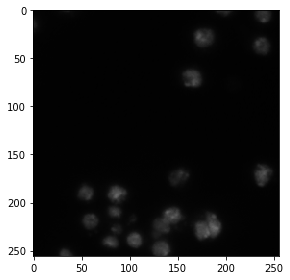

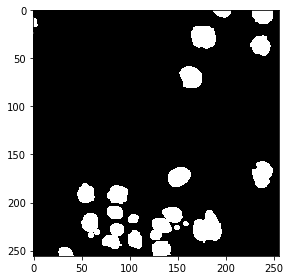

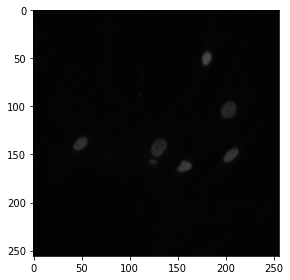

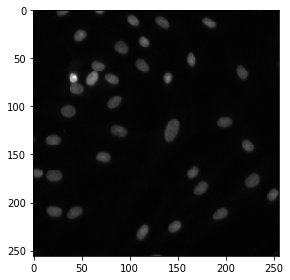

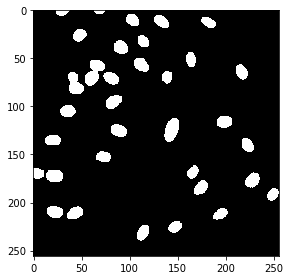

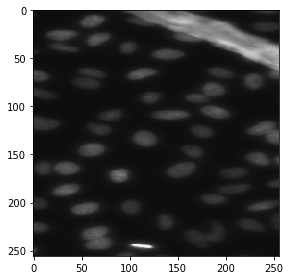

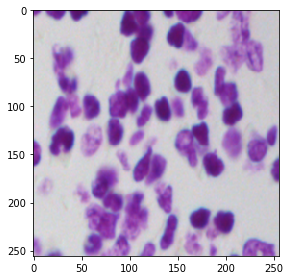

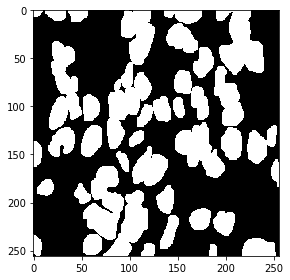

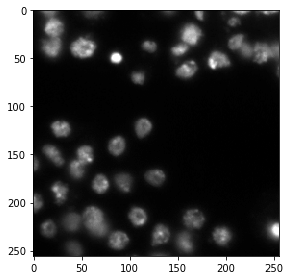

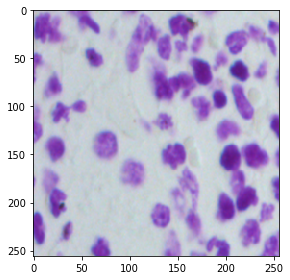

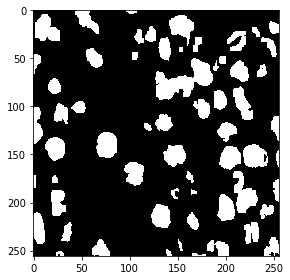

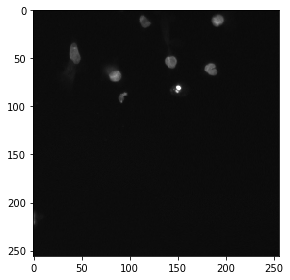

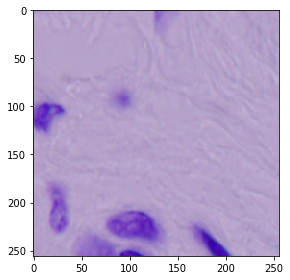

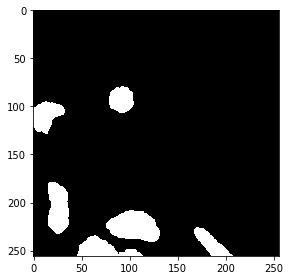

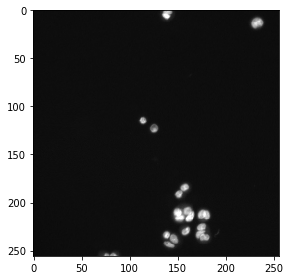

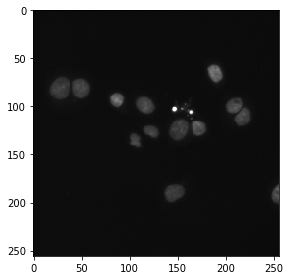

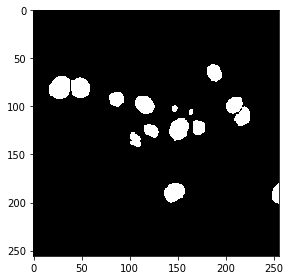

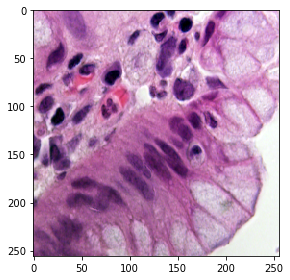

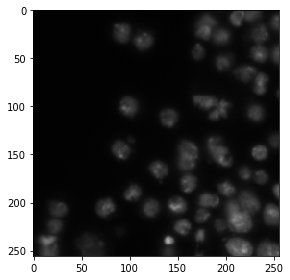

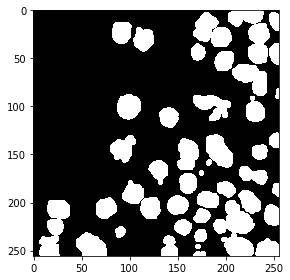

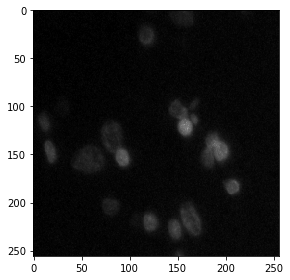

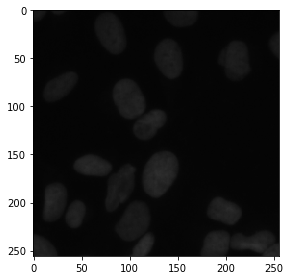

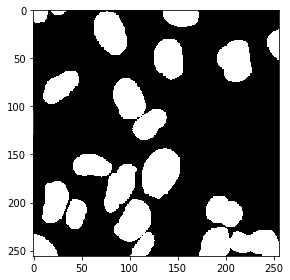

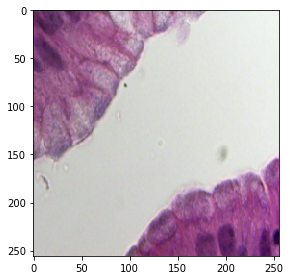

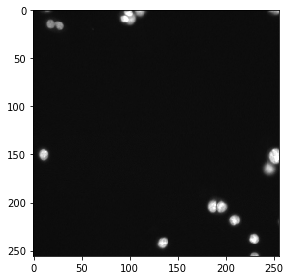

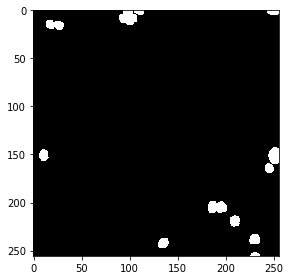

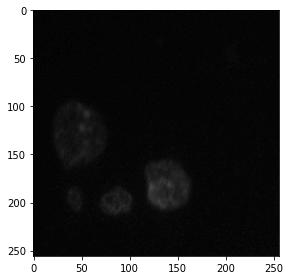

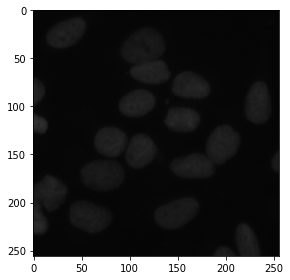

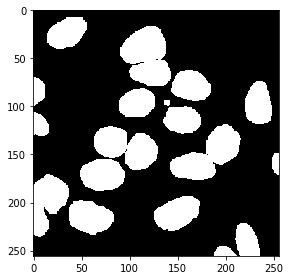

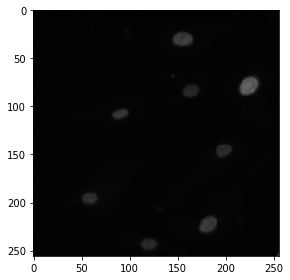

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import os
import numpy as np

if __name__=="__main__":
    img_size=256
    batch_size=32
    #path = os.getcwd()
    train_path = "/dataset/stage1_train/"
    test_path = "/dataset/stage1_test/"

    X_train, Y_train, X_test, sizes_test = make_df(train_path, test_path, img_size)
    
    xtr, xval, ytr, yval = train_test_split(X_train, Y_train, test_size=0.1, random_state=7)
    train_generator, val_generator = generator(xtr, xval, ytr, yval, batch_size)

#     model=Unet_model(img_size)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

#     model.fit_generator(train_generator, steps_per_epoch=len(xtr)/6, epochs=60, validation_data=val_generator, validation_steps=len(xval)/batch_size)
#     preds_test=model.predict(X_test, verbose=1)

#     preds_test_unsampled=[]
#     for i in range(len(preds_test)):
#         preds_test_unsampled.append(cv2.resize(preds_test[i], (sizes_test[i][1], sizes_test[i][0])))
#         test_ids=next(os.walk(test_path))[1]
#         new_test_ids=[]
#         rles=[]

#     for n, id_ in enumerate(test_ids):
#         #print(n, id_)
#         rle = list(prob_to_rles(preds_test_unsampled[n]))
#         rles.extend(rle)
#         new_test_ids.extend([id_]*len(rle))
#     sub=pd.DataFrame()
#     sub['ImageId']=new_test_ids
#     sub['EncodedPixels']=pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
#     sub.to_csv('subDataScienceBowl2018_ep60_unet_dataaug_v1.csv')

/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


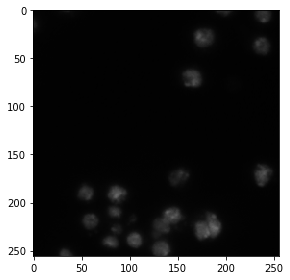

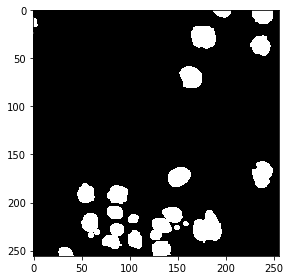

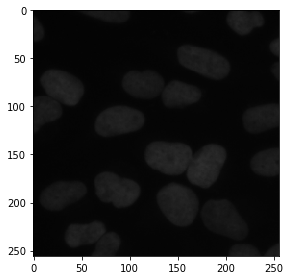

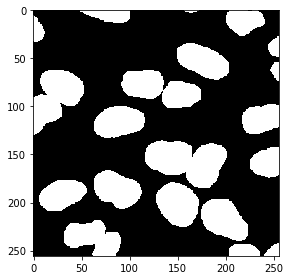

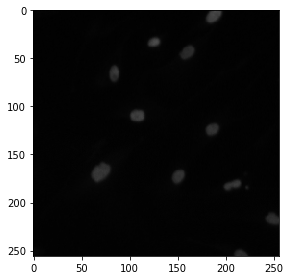

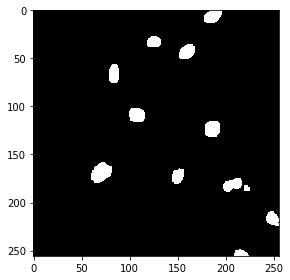

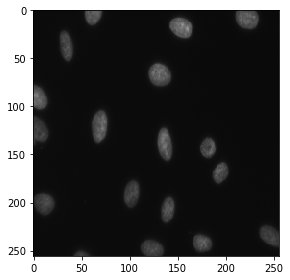

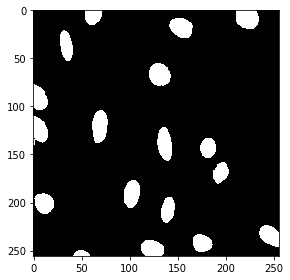

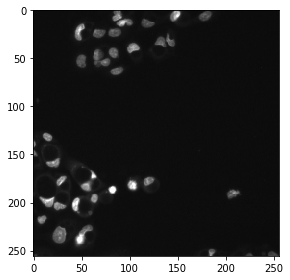

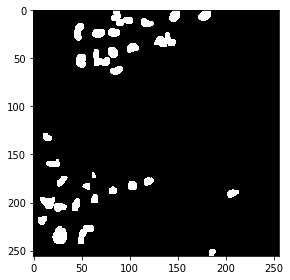

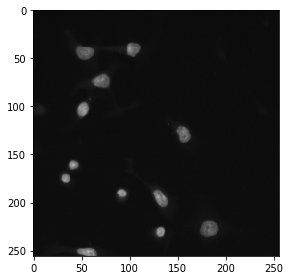

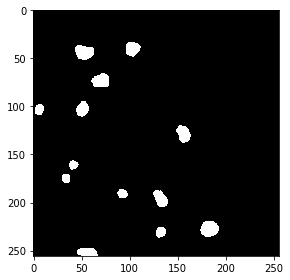

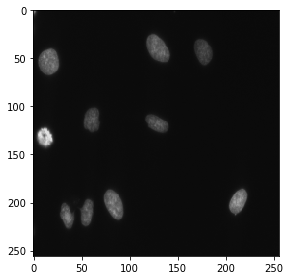

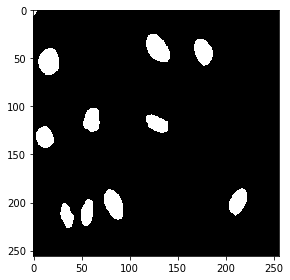

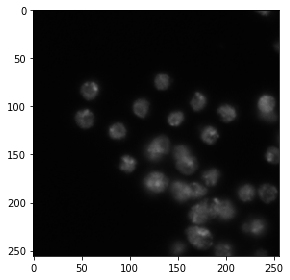

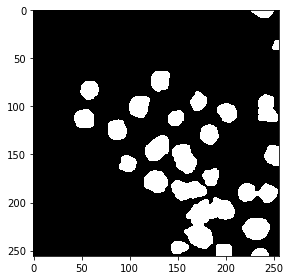

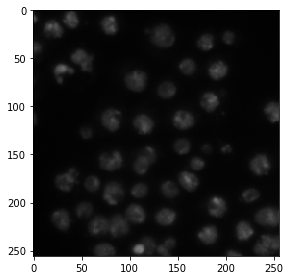

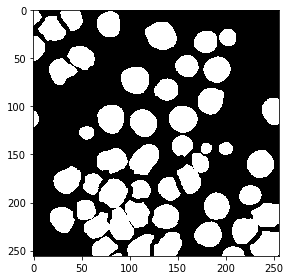

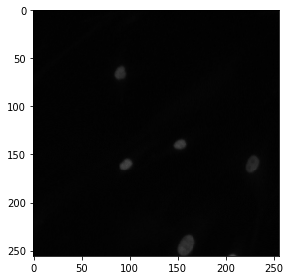

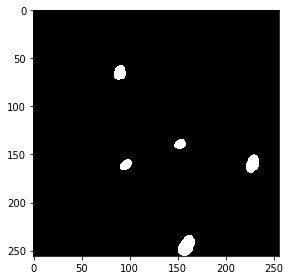

In [14]:
for i in range(10):
        imshow(X_train[-i])
        plt.show()
        imshow(np.squeeze(Y_train[-i]))
        plt.show()
#         imshow(X_test[i])
#         plt.show()

In [16]:
    model=Unet_model(img_size)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

    model.fit_generator(train_generator, steps_per_epoch=len(xtr)/6, epochs=20, validation_data=val_generator, validation_steps=len(xval)/batch_size)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

Epoch 1/20
101/100 [==============================] - 99s 979ms/step - loss: 0.4604 - mean_iou: 0.4223 - val_loss: 0.4442 - val_mean_iou: 0.4259
Epoch 2/20
101/100 [==============================] - 96s 955ms/step - loss: 0.4262 - mean_iou: 0.4256 - val_loss: 0.4167 - val_mean_iou: 0.4254
Epoch 3/20
101/100 [==============================] - 96s 955ms/step - loss: 0.4252 - mean_iou: 0.4253 - val_loss: 0.3585 - val_mean_iou: 0.4252
Epoch 4/20
101/100 [==============================] - 97s 957ms/step - loss: 0.4224 - mean_iou: 0.4252 - val_loss: 0.4125 - val_mean_iou: 0.4251
Epoch 5/20
101/100 [==============================] - 96s 955ms/step - loss: 0.4146 - mean_iou: 0.4250 - val_loss: 0.3547 - val_mean_iou: 0.4250
Epoch 6/20
101/100 [==============================] - 96s 954ms/step - loss: 0.2895 - mean_iou: 0.4325 - val_loss: 0.2079 - val_mean_iou: 0.4457
Epoch 7/20
101/100 [==============================] - 97s 957ms/step - loss: 0.2349 - mean_iou: 0.4581 - val_loss: 0.2174 - val_me

In [19]:
preds_test=model.predict(X_test, verbose=1)
preds_test_unsampled=[]
for i in range(len(preds_test)):
    preds_test_unsampled.append(cv2.resize(preds_test[i], (sizes_test[i][1], sizes_test[i][0])))
    test_ids=next(os.walk(test_path))[1]
    new_test_ids=[]
    rles=[]

for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_unsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_]*len(rle))
sub=pd.DataFrame()
sub['ImageId']=new_test_ids
sub['EncodedPixels']=pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('subDataScienceBowl2018_ep20_unet_dataaug_v1.csv')

65/65 [==============================] - 1s 17ms/step


## Best Submission yet , This submission reached a LB score of 0.282
+ This is my Best submission yet on 3/18 . LB score = 0.282 , ranks at top 60% 
+ This is a significant improvement from my simple CNN submission which achieves only 0.146 score
+ Further improvement could be put here by the use of data Augmentation, which will be mu next attempt
+ Looking over some of the kernels, I see that I am doing better than most of the other kernels that were in the discussion forums , so I think it will be tough to go beyond this
+ The Model is based on https://arxiv.org/abs/1505.04597 , seems the unet architecture came up in 2015 and was considered best at that time for Biomedical image segmentation
+ I will aslo see if I can improve and tweak on the current U-net model to achieve a better score without image augmentation